In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn.plotting as nil
import glob
import os
import radiomics
from math import isclose
from scipy import ndimage, spatial
from sklearn.preprocessing import StandardScaler
from nibabel.affines import apply_affine
import ipympl
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
path_data = "/mnt/data/ffrouin/NEOTEX/DATA_NIFTI/DataMerged/85"

image_path = glob.glob(path_data + '/RawVolume/*dyn1*_Bspline_zscore_without_tumour.nii.gz')
mask_bb_path = glob.glob(path_data + '/RoiVolume/Bounding_box.nii.gz')
mask_path = glob.glob(path_data + '/RoiVolume/C1_volume_resampled_NN_40.0.nii.gz')

image = nib.load(image_path[0])
mask_bb = nib.load(mask_bb_path[0])
mask = nib.load(mask_path[0])

In [3]:
a_im = np.flip(np.rot90(np.array(image.dataobj), k=1), axis=0)
a_ma = np.flip(np.rot90(np.array(mask.dataobj), k=1), axis=0)
a_ma_bb = np.flip(np.rot90(np.array(mask_bb.dataobj), k=1), axis=0)

In [4]:
data = image.get_fdata()
flipped_data = np.flip(data, axis=1)

data_mask_bb = mask_bb.get_fdata()
mask_bb_flipped_data = np.flip(data_mask_bb, axis=1)

In [5]:
inside_bb = a_ma_bb * a_im
to_display = np.ma.masked_equal(inside_bb, 0)

inside_mask_bb_mosaic = flipped_data * mask_bb_flipped_data
to_display_mosaic = np.ma.masked_equal(inside_mask_bb_mosaic, 0)

In [6]:
x, y, z = np.where(~to_display.mask)
x_min = x.min()
x_max = x.max()
y_min = y.min()
y_max = y.max()
z_min = z.min()
z_max = z.max() 

x_mos, y_mos, z_mos = np.where(~to_display_mosaic.mask)
x_min_mos = x_mos.min()
x_max_mos = x_mos.max()
y_min_mos = y_mos.min()
y_max_mos = y_mos.max()
z_min_mos = z_mos.min()
z_max_mos = z_mos.max() 

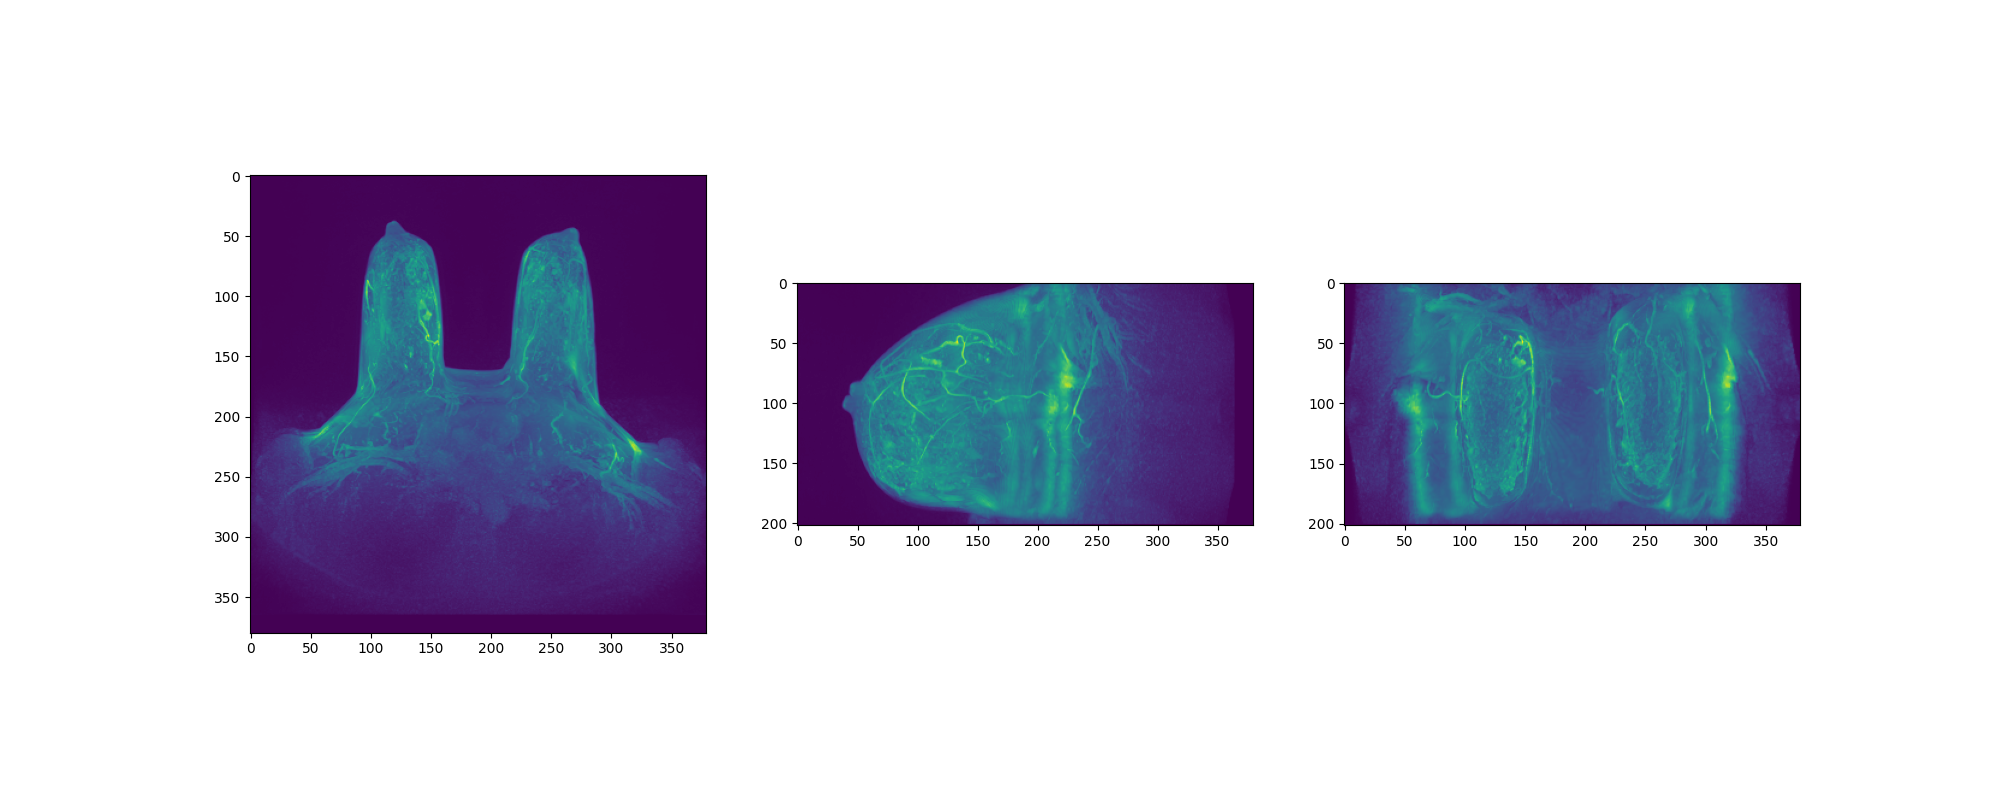

In [7]:
mip_ax= np.max(a_im, axis=2)
mip_sag= np.rot90(np.max(a_im, axis=1))
mip_cor= np.rot90(np.max(a_im, axis=0))
plt.close('all')


_, axs = plt.subplots(1, 3, figsize=(20, 8))
for img, ax in zip([mip_ax, mip_sag, mip_cor], axs):
    ax.imshow(img)
plt.show()

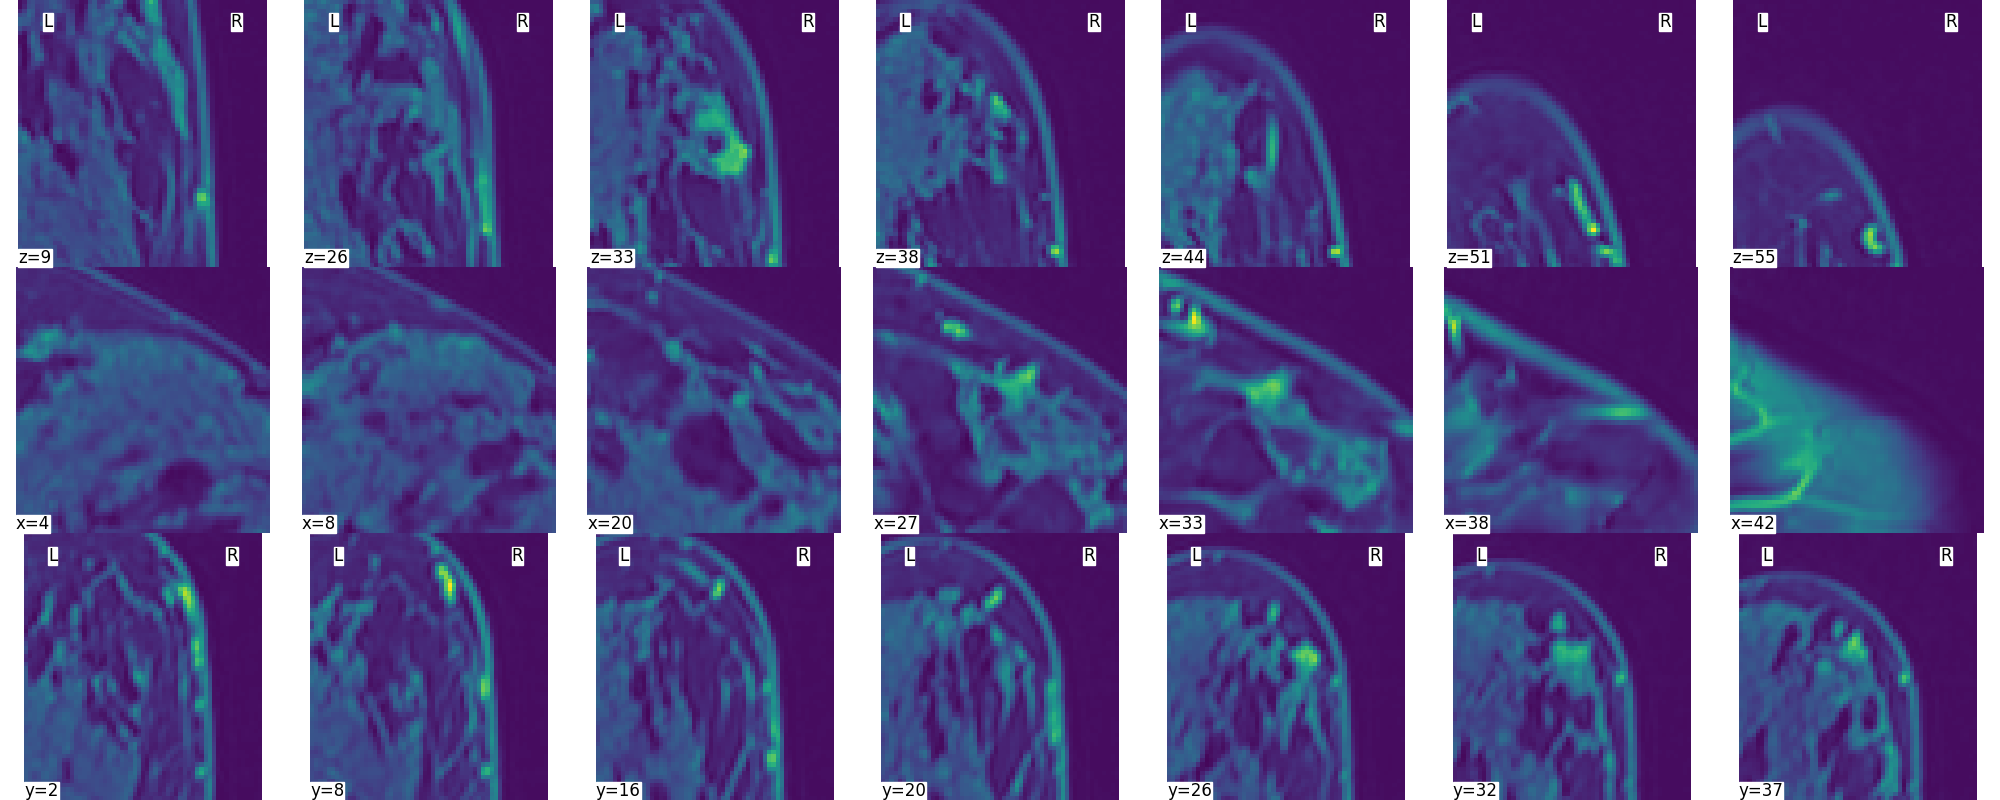

In [8]:
cos_gamma = np.cos(-1.5708)
sin_gamma = np.sin(-1.5708)
translation_affine = np.eye(4)
translation_affine[:, 3] = image.affine[:, 3]
rotation_affine = np.array([[cos_gamma, -sin_gamma, 0, 0],
                            [sin_gamma, cos_gamma , 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])

affine = translation_affine.dot(rotation_affine)
plt.close('all')
new_image = nib.Nifti1Image(flipped_data[x_min_mos-20:x_max_mos+20, y_min_mos-20:y_max_mos+20, z_min_mos-20:z_max_mos+20], affine=np.eye(4))
_min, _max = np.amin(flipped_data[x_min_mos-20:x_max_mos+20, y_min_mos-20:y_max_mos+20, z_min_mos-20:z_max_mos+20]), np.amax(flipped_data[x_min_mos-20:x_max_mos+20, y_min_mos-20:y_max_mos+20, z_min_mos-20:z_max_mos+20])
fig = plt.figure(figsize=(20, 8))
nil.plot_img(new_image, display_mode="mosaic", figure=fig, vmin = _min, vmax = _max)

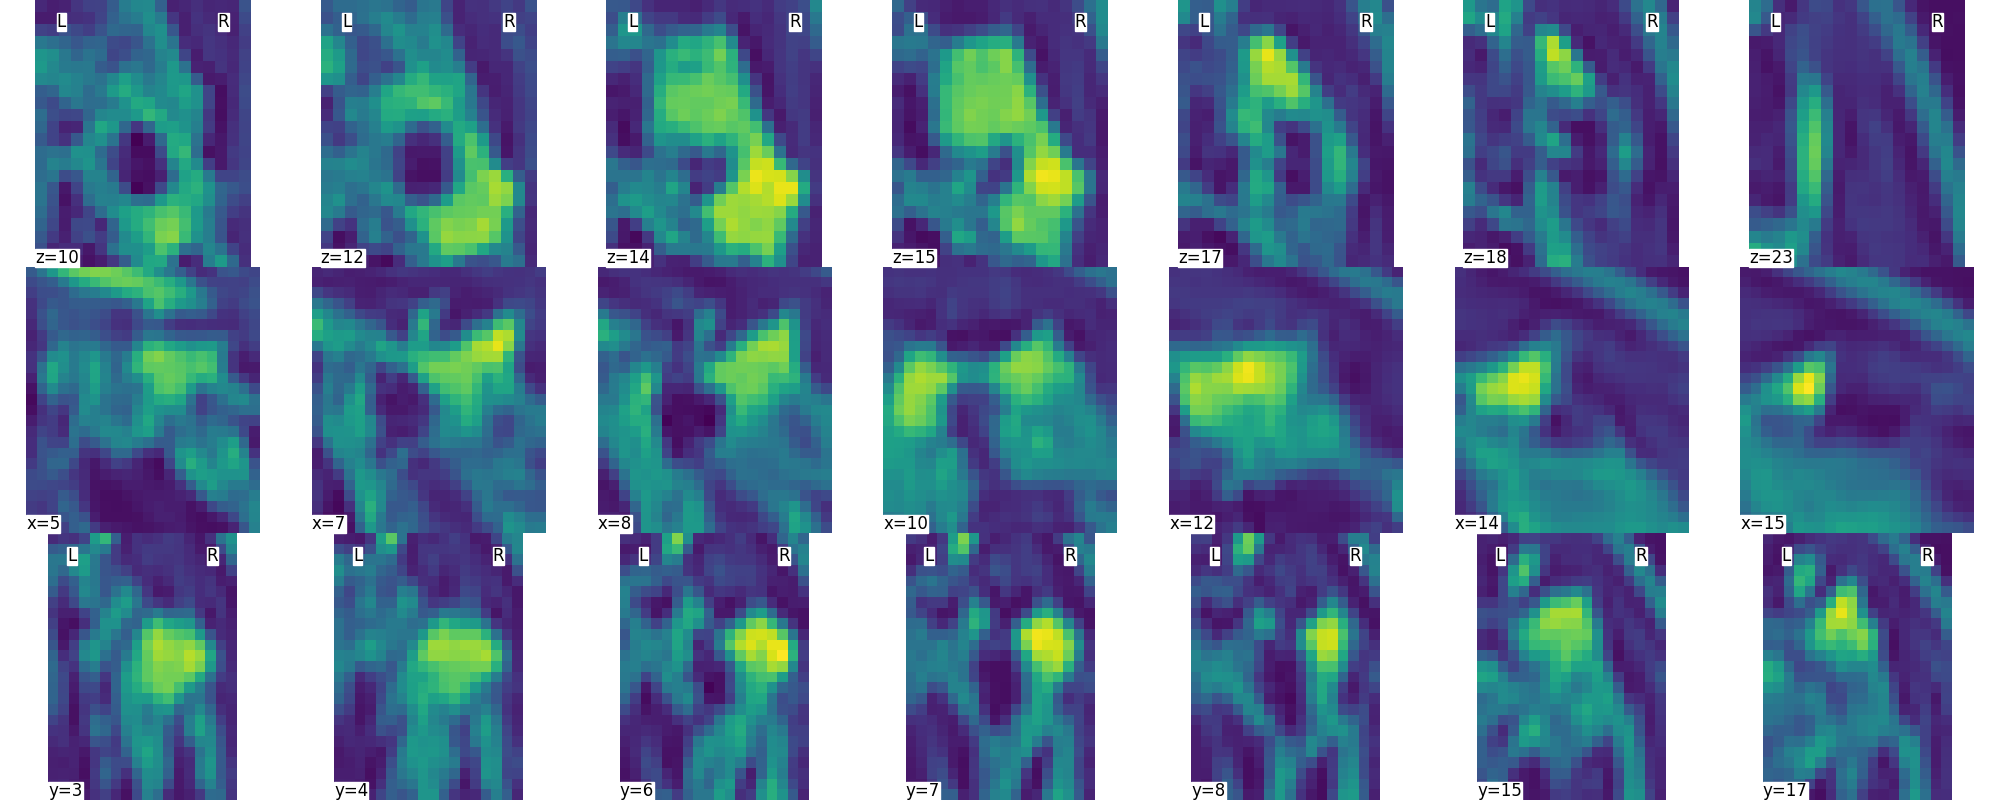

In [9]:
plt.close('all')
new_image = nib.Nifti1Image(flipped_data[x_min_mos:x_max_mos+1, y_min_mos:y_max_mos+1, z_min_mos:z_max_mos+1], affine=np.eye(4))
_min, _max = np.amin(flipped_data[x_min_mos:x_max_mos+1, y_min_mos:y_max_mos+1, z_min_mos:z_max_mos+1]), np.amax(flipped_data[x_min_mos:x_max_mos+1, y_min_mos:y_max_mos+1, z_min_mos:z_max_mos+1])
fig = plt.figure(figsize=(20, 8))
nil.plot_img(new_image, display_mode="mosaic", figure=fig, vmin = _min, vmax = _max)


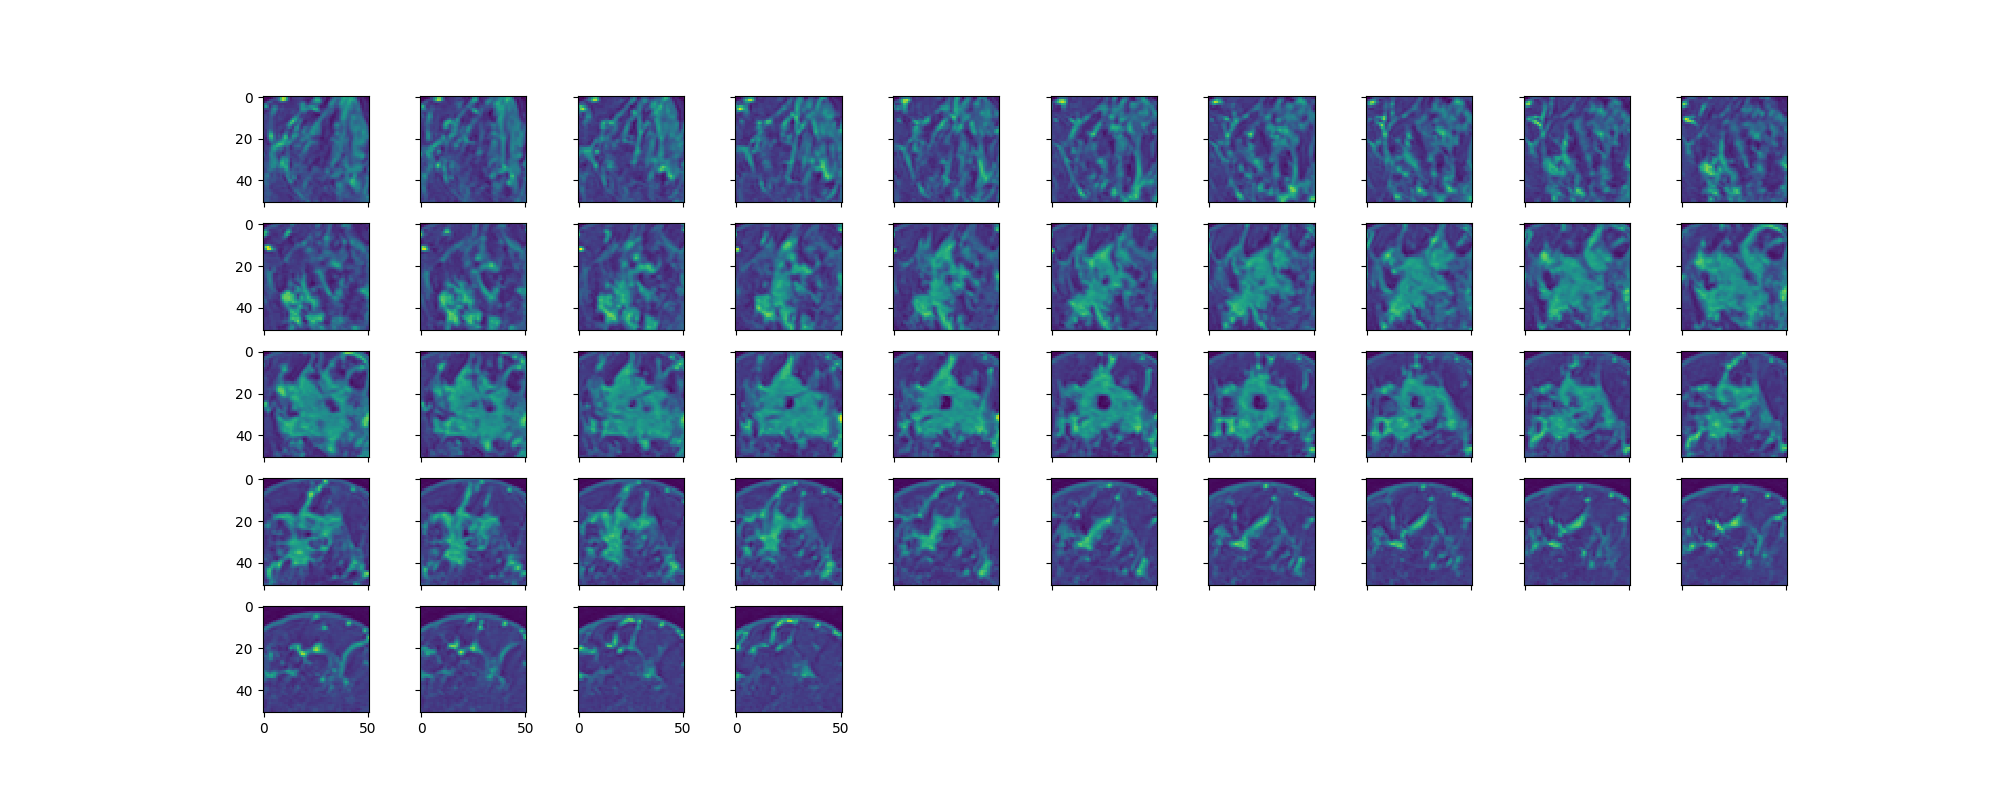

In [13]:
n_cuts = z_max+1-z_min
n_columns = 10
n_rows = n_cuts // n_columns 

plt.close('all')

if n_cuts % n_columns != 0:
    n_rows += 1
x_min_iso = int(x_max - (x_max-x_min)/2 - 25)
x_max_iso = int(x_max - (x_max-x_min)/2 + 25)
y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
y_max_iso = int(y_max - (y_max-y_min)/2 + 25)

if x_max - x_min < 50:
    to_display[x_min_iso:x_min+1, y_min_iso:y_max_iso+1]=0
    to_display[x_max:x_max_iso+1, y_min_iso:y_max_iso+1]=0

if y_max - y_min < 50:
    to_display[x_min_iso:x_max_iso+1, y_min_iso:y_min]=0
    to_display[x_min_iso:x_max_iso+1, y_max:y_max_iso+1]=0
_min, _max = np.amin(to_display[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]), np.amax(to_display[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1])
_, axs = plt.subplots(n_rows, n_columns, figsize=(20, 8), sharex=True, sharey=True)
axs = axs.flatten()
for img, ma, ax in zip([to_display[x_min_iso:x_max_iso+1, y_min_iso:y_max_iso+1, k] for k in range(z_min, z_max+1)], [a_ma[x_min_iso:x_max_iso+1, y_min_iso:y_max_iso+1, k] for k in range(z_min, z_max+1)], axs):
    ax.imshow(img, vmin = _min, vmax = _max, interpolation='none')
    ax.imshow(ma, alpha=0.25*(ma>0))

for ax in axs:
    if not bool(ax.get_images()):
        ax.remove()
plt.show()

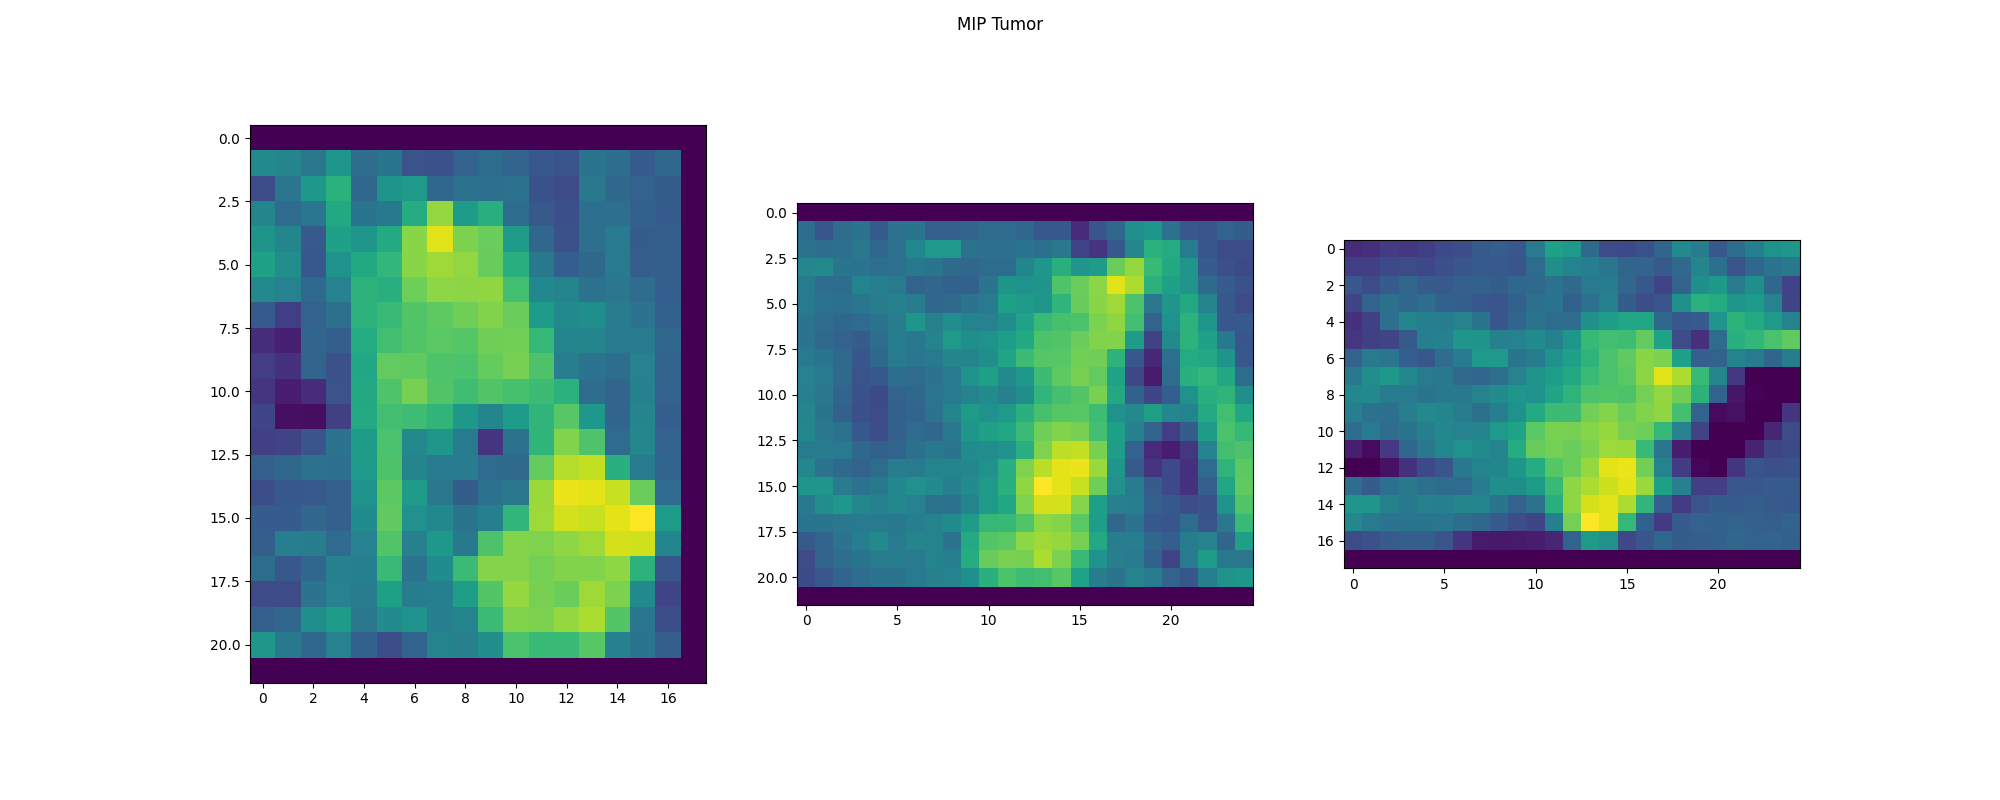

In [11]:
mip_ax= np.max(to_display, axis=2)
mip_sag= np.max(to_display, axis=1)
mip_cor= np.max(to_display, axis=0)
plt.close('all')


fig, axs = plt.subplots(1, 3, figsize=(20, 8))
for img, ax in zip([mip_ax[x_min:x_max+1, y_min:y_max+1], mip_sag[x_min:x_max+1, z_min:z_max+1], mip_cor[y_min:y_max+1, z_min:z_max+1]], axs):
    ax.imshow(img)
fig.suptitle('MIP Tumor')
plt.show()

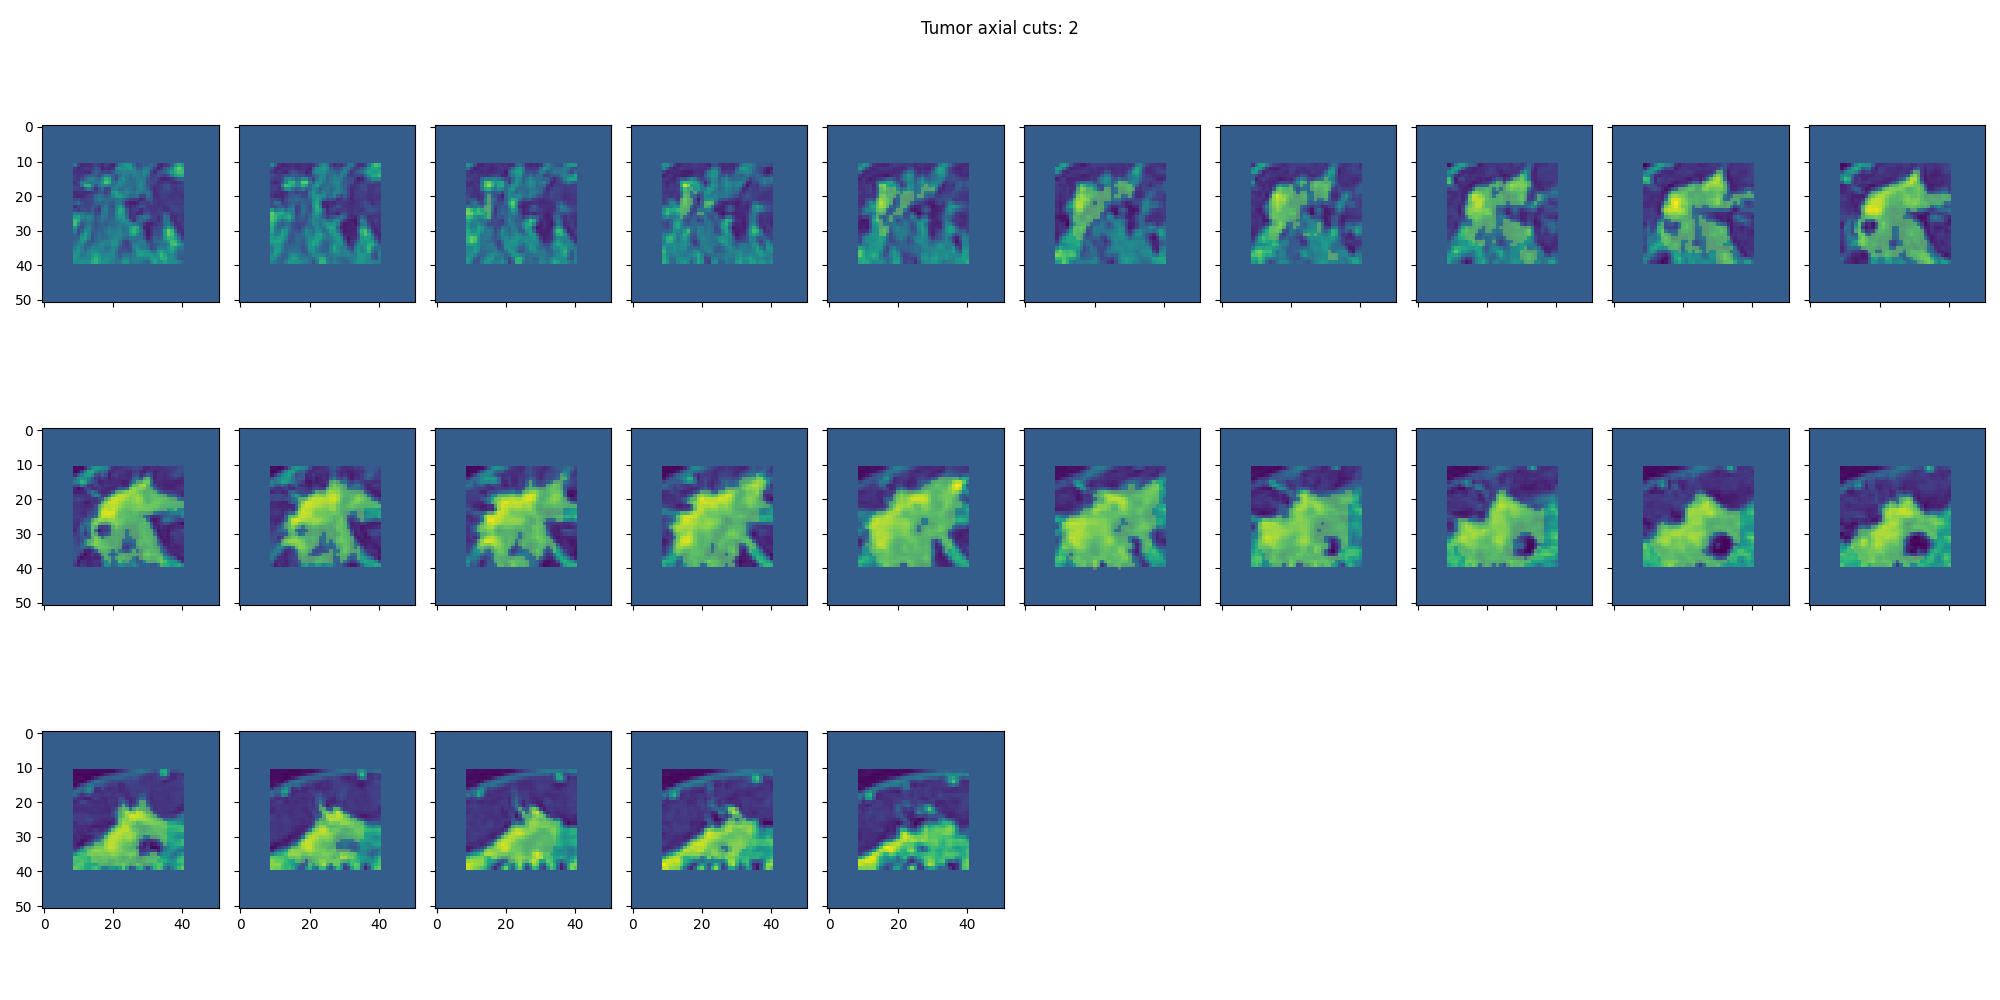

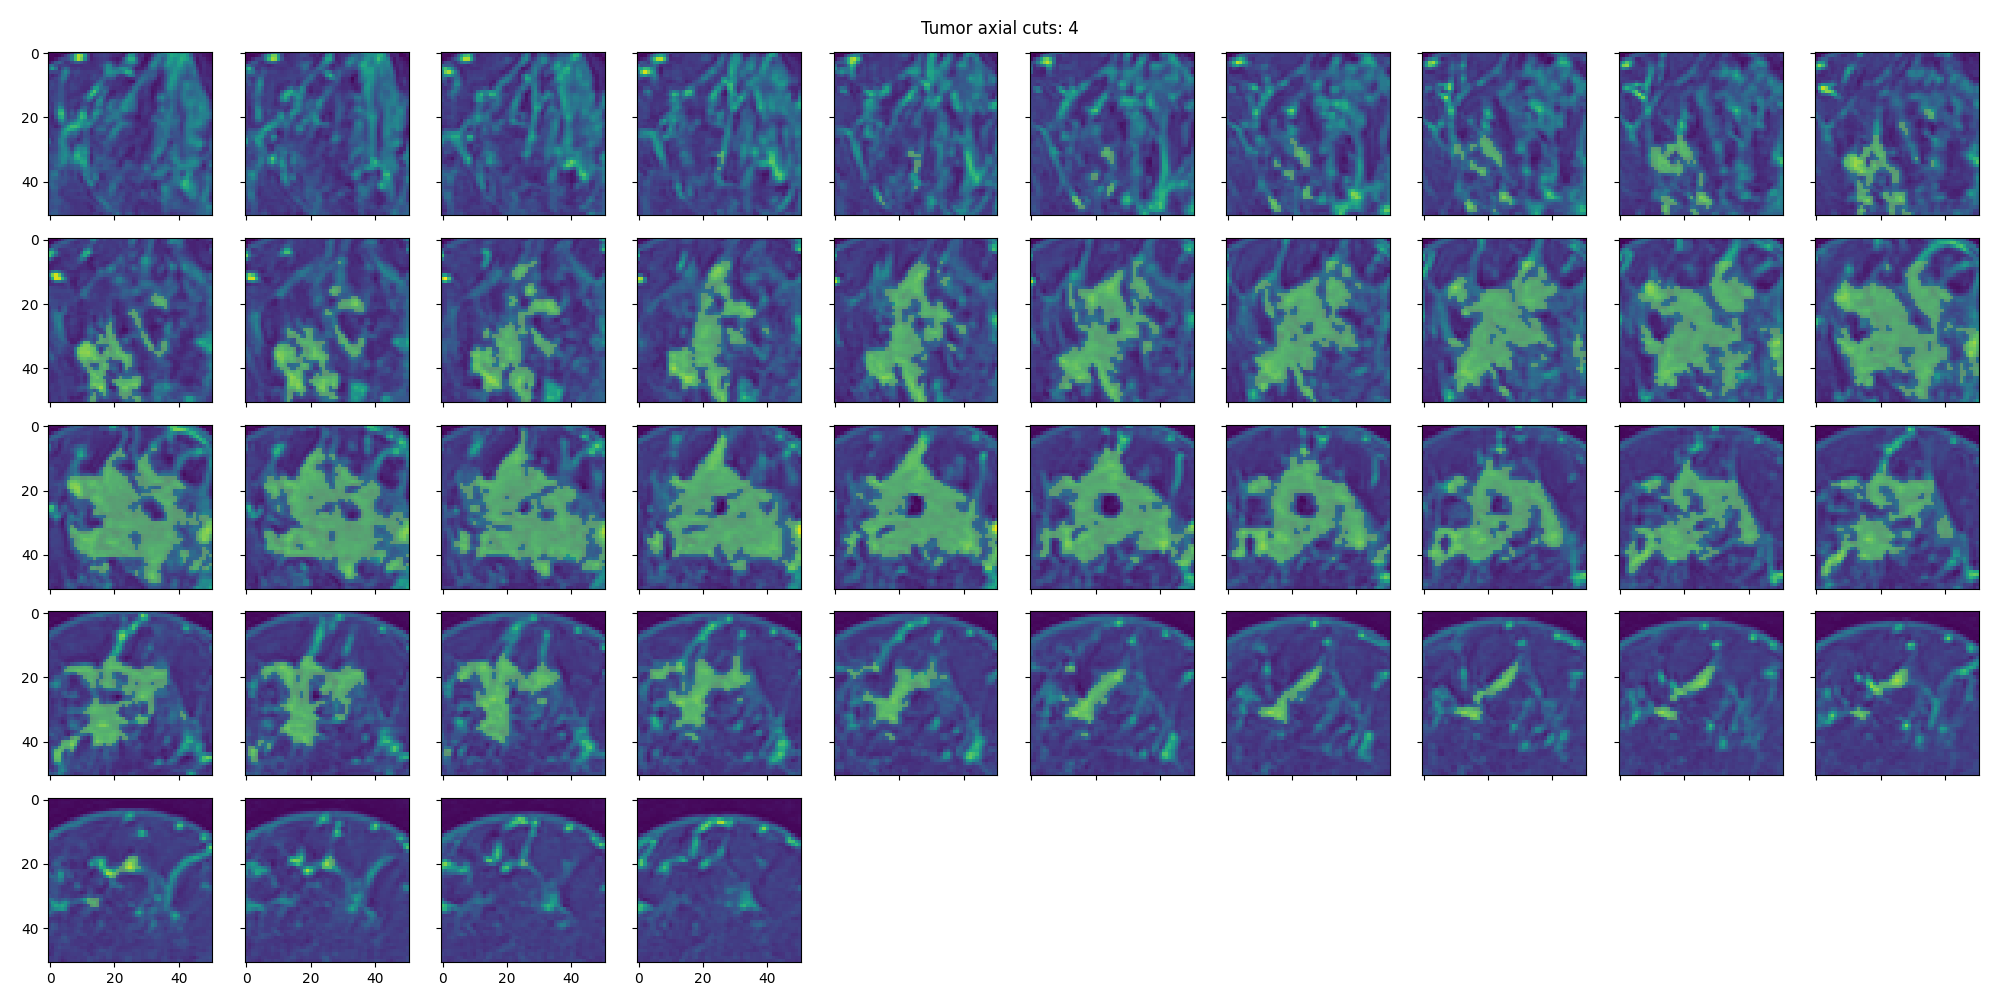

KeyboardInterrupt: 

In [12]:
plt.close('all')
for i in [2, 4, 6, 8, 9, 12, 13, 18, 19, 20, 23, 24, 25, 26, 27, 29, 31, 32, 36, 37, 41, 42, 45, 47, 48, 52, 53, 55, 57, 59, 60, 61, 62, 63, 65, 68, 77, 78, 80, 84, 86, 87, 89, 91, 93, 94, 98, 101]:
    
    path_data = "/mnt/data/ffrouin/NEOTEX/DATA_NIFTI/DataMerged/" + str(i)

    image_path = glob.glob(path_data + '/RawVolume/*dyn1*_Bspline_zscore_without_tumour.nii.gz')
    mask_bb_path = glob.glob(path_data + '/RoiVolume/Bounding_box.nii.gz')
    mask_path = glob.glob(path_data + '/RoiVolume/C1_volume_resampled_NN_40.0.nii.gz')

    image = nib.load(image_path[0])
    mask_bb = nib.load(mask_bb_path[0])
    mask = nib.load(mask_path[0])

    a_im = np.flip(np.rot90(np.array(image.dataobj), k=1), axis=0)
    a_ma = np.flip(np.rot90(np.array(mask.dataobj), k=1), axis=0)
    a_ma_bb = np.flip(np.rot90(np.array(mask_bb.dataobj), k=1), axis=0)

    inside_bb = a_ma_bb * a_im
    to_display = np.ma.masked_equal(inside_bb, 0)

    x, y, z = np.where(~to_display.mask)
    x_min = x.min()
    x_max = x.max()
    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max() 

    x_min_iso = int(x_max - (x_max-x_min)/2 - 25)
    x_max_iso = int(x_max - (x_max-x_min)/2 + 25)
    y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
    y_max_iso = int(y_max - (y_max-y_min)/2 + 25)

    if x_max - x_min < 50:
        to_display[x_min_iso:x_min+1, y_min_iso:y_max_iso+1]=0
        to_display[x_max:x_max_iso+1, y_min_iso:y_max_iso+1]=0

    if y_max - y_min < 50:
        to_display[x_min_iso:x_max_iso+1, y_min_iso:y_min]=0
        to_display[x_min_iso:x_max_iso+1, y_max:y_max_iso+1]=0
    
    n_cuts = z_max+1-z_min
    n_columns = 10
    n_rows = n_cuts // n_columns 

    if n_cuts % n_columns != 0:
        n_rows += 1

    _min, _max = np.amin(to_display[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]), np.amax(to_display[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1])
    
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(20, 10), sharex=True, sharey=True)
    axs = axs.flatten()
    for img, ma, ax in zip([to_display[x_min_iso:x_max_iso+1, y_min_iso:y_max_iso+1, k] for k in range(z_min, z_max+1)], [a_ma[x_min_iso:x_max_iso+1, y_min_iso:y_max_iso+1, k] for k in range(z_min, z_max+1)], axs):
        ax.imshow(img, vmin = _min, vmax = _max, interpolation='none')
        ax.imshow(ma, alpha=0.25*(ma>0))

    for ax in axs:
        if not bool(ax.get_images()):
            ax.remove()
    fig.suptitle('Tumor axial cuts: ' + str(i))
    fig.tight_layout()
    plt.show()

In [ ]:
for i in [1, 5, 7, 10, 14, 15,16, 17, 21, 22, 28, 30, 33, 34,35, 38, 39, 40, 43, 44, 46, 49, 50, 51, 54, 56, 58, 64, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 79, 81, 82, 83, 85, 88, 90, 92, 95, 96, 97, 99, 100, 102, 103, 104, 105]:
    path_data = "/mnt/data/ffrouin/NEOTEX/DATA_NIFTI/DataMerged/" + str(i)

    image_path = glob.glob(path_data + '/RawVolume/*dyn1*_Bspline_zscore_without_tumour.nii.gz')
    mask_bb_path = glob.glob(path_data + '/RoiVolume/Bounding_box.nii.gz')
    mask_path = glob.glob(path_data + '/RoiVolume/C1_volume_resampled_NN_40.0.nii.gz')

    image = nib.load(image_path[0])
    mask_bb = nib.load(mask_bb_path[0])
    mask = nib.load(mask_path[0])

    a_im = np.flip(np.rot90(np.array(image.dataobj), k=1), axis=0)
    a_ma = np.flip(np.rot90(np.array(mask.dataobj), k=1), axis=0)
    a_ma_bb = np.flip(np.rot90(np.array(mask_bb.dataobj), k=1), axis=0)

    inside_bb = a_ma_bb * a_im
    to_display = np.ma.masked_equal(inside_bb, 0)

    x, y, z = np.where(~to_display.mask)
    x_min = x.min()
    x_max = x.max()
    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max() 

    x_min_iso = int(x_max - (x_max-x_min)/2 - 25)
    x_max_iso = int(x_max - (x_max-x_min)/2 + 25)
    y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
    y_max_iso = int(y_max - (y_max-y_min)/2 + 25)

    if x_max - x_min < 50:
        to_display[x_min_iso:x_min+1, y_min_iso:y_max_iso+1]=0
        to_display[x_max:x_max_iso+1, y_min_iso:y_max_iso+1]=0

    if y_max - y_min < 50:
        to_display[x_min_iso:x_max_iso+1, y_min_iso:y_min]=0
        to_display[x_min_iso:x_max_iso+1, y_max:y_max_iso+1]=0
    
    n_cuts = z_max+1-z_min
    n_columns = 10
    n_rows = n_cuts // n_columns 

    if n_cuts % n_columns != 0:
        n_rows += 1

    _min, _max = np.amin(to_display[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]), np.amax(to_display[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1])
    
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(20, 8), sharex=True, sharey=True)
    axs = axs.flatten()
    for img, ma, ax in zip([to_display[x_min_iso:x_max_iso+1, y_min_iso:y_max_iso+1, k] for k in range(z_min, z_max+1)], [a_ma[x_min_iso:x_max_iso+1, y_min_iso:y_max_iso+1, k] for k in range(z_min, z_max+1)], axs):
        ax.imshow(img, vmin = _min, vmax = _max, interpolation='none')
        ax.imshow(ma, alpha=0.25*(ma>0))

    for ax in axs:
        if not bool(ax.get_images()):
            ax.remove()
    fig.suptitle('Tumor axial cuts: ' + str(i))
    fig.tight_layout()
    plt.show()